# TipTrack CNN Training

In [1]:
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback
import visualkeras
# from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness

# Custom python class for preparing the dataset. This will prevent the notebook from being too messy
from prepare_dataset import PrepareDataset

# Ignore CPU warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-02-27 11:10:45.687749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2023-02-27 11:10:45.687802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMG_SIZE = 48  # The expected size of the input images

TARGET_FOLDER = 'training_images/2023-02-22'  # The folder containing the new images

MODEL_NAME = 'model_2023_003'  # How the output model should be named at the end

## Prepare the training and test dataset

All folders with "DRAW"  images:  ['training_images/2023-02-22/draw_0_600_18']
All folders with "HOVER" images:  ['training_images/2023-02-22/hover_far_0_600_18', 'training_images/2023-02-22/hover_close_0_600_18']


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 
We have 19200 images in the training dataset and 600 images in the test dataset
The training dataset consists of 6400 draw images and 12800 hover images
 


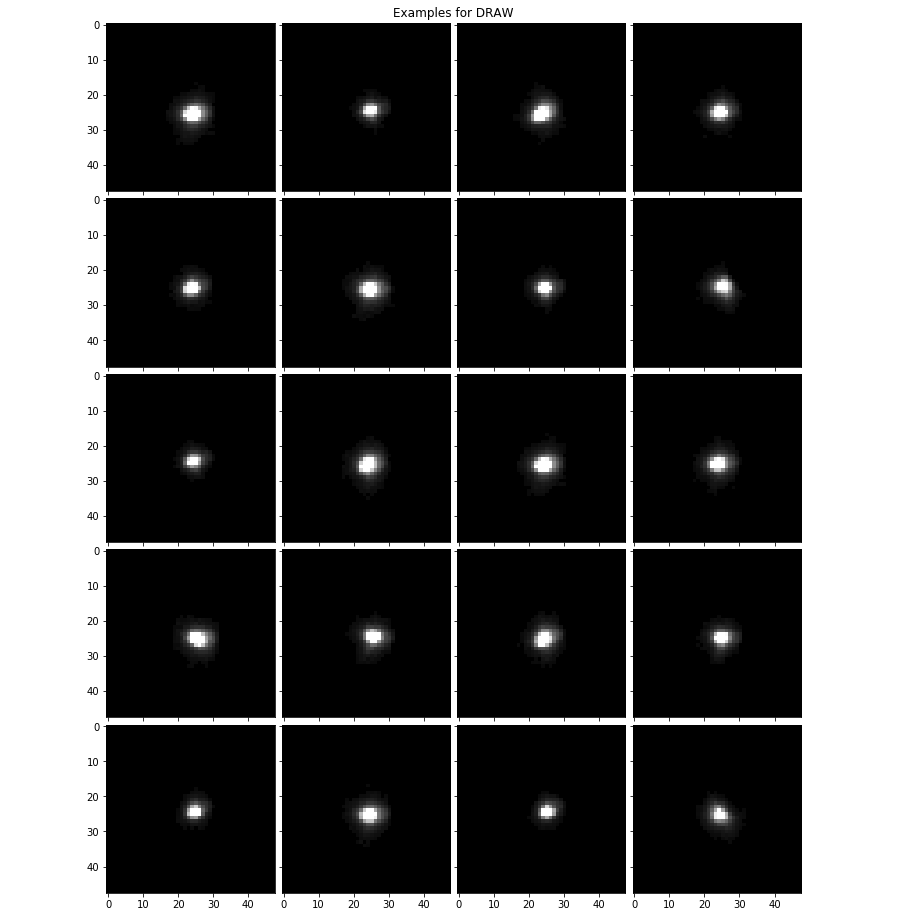

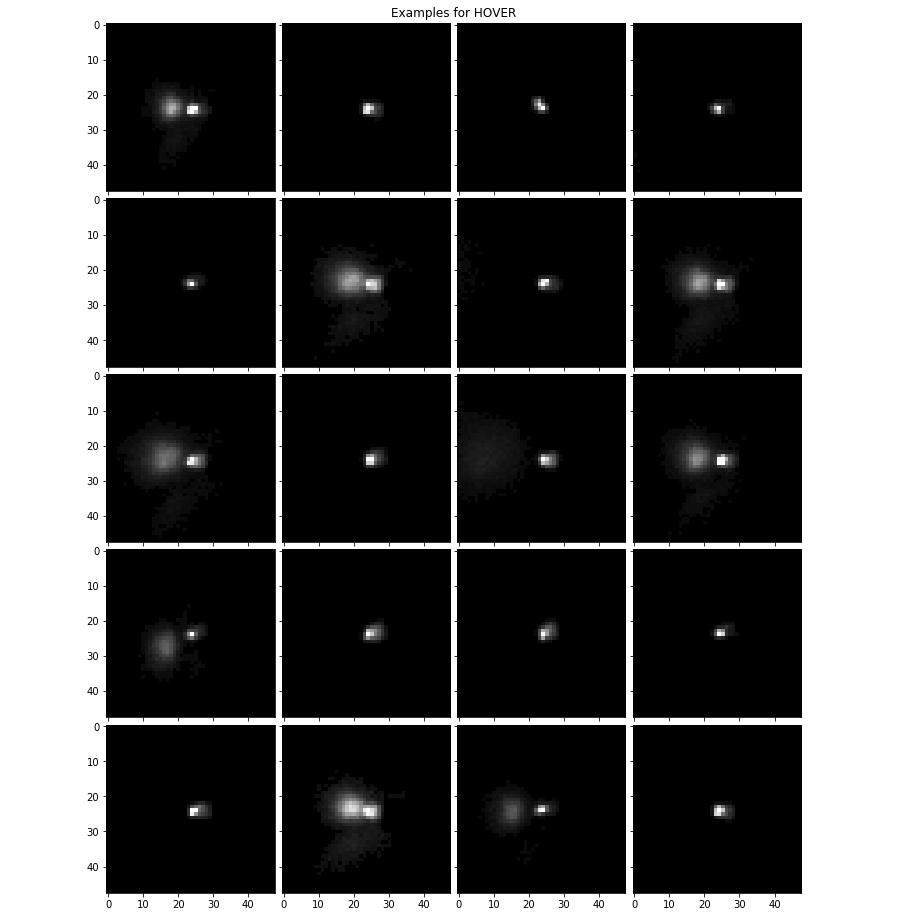

In [3]:
prepare_dataset = PrepareDataset()

train_X, train_label, test_X, test_label = prepare_dataset.get_dataset(TARGET_FOLDER, IMG_SIZE)

## Init Keras Model

**Breakdown of the current architecture:**

The model is defined as a Sequential object, meaning layers will be added in a sequential manner.

The first layer added is a Conv2D layer with 64 filters, each with a kernel size of 3x1, and a linear activation function. The input shape is (48, 48, 1), which means the input is a grayscale image with dimensions 48x48. The padding is set to 'same', which means the output will have the same spatial dimensions as the input.

The next layer is another Conv2D layer with 64 filters, this time with a kernel size of 1x3 and also with a linear activation function. The padding is set to 'same'.

A MaxPooling2D layer is added with a pool size of 2x2 and padding set to 'same'. This layer reduces the spatial dimensions of the output by a factor of 2.

Two more pairs of Conv2D and MaxPooling2D layers are added, each with a lower number of filters (32) but larger kernel sizes (3x1 and 1x3). The padding is set to 'same' for both convolutional layers, and the pool size is again 2x2 with padding set to 'same' for both pooling layers. A Dropout layer with rate 0.2 is added after the second pair of convolutional and pooling layers.

A Flatten layer is added to flatten the output of the previous layer into a 1D array.

Four Dense layers with 128 units each and a ReLU activation function are added in sequence.

Another Dropout layer with rate 0.2 is added after the fifth Dense layer.

A final Dense layer with 2 units (one for each possible class) and a softmax activation function is added.

The model is compiled using categorical_crossentropy as the loss function, the Adam optimizer, and accuracy as the metric to monitor during training.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        256       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        6176      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        3104      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                    

2023-02-27 11:10:53.459793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 11:10:53.460477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2023-02-27 11:10:53.460753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2023-02-27 11:10:53.460965: 

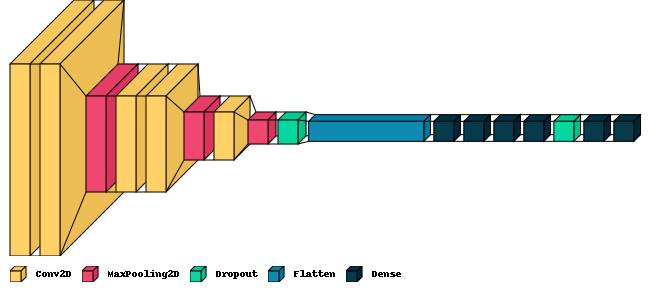

In [4]:

# conv linear


num_classes = 2
activation = 'relu'
activation_conv = 'linear'  # LeakyReLU
num_neurons = 128

# Define model structure
model = Sequential()

# model.add(data_augmentation_new)
model.add(Conv2D(64, kernel_size=(3, 1), activation=activation_conv, input_shape=(IMG_SIZE, IMG_SIZE, 1), padding='same'))
model.add(Conv2D(64, (1, 3), activation=activation_conv, padding='same'))

# Reduce the spatial dimensions of the output by a factor of 2
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, (3, 1), activation=activation_conv, padding='same'))
model.add(Conv2D(32, (1, 3), activation=activation_conv, padding='same'))

# Reduce the spatial dimensions of the output by a factor of 2
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))

# Reduce the spatial dimensions of the output by a factor of 2
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Dropout(0.2))

# model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_neurons, activation=activation))

model.add(Dropout(0.2))

model.add(Dense(num_neurons, activation=activation))
# model.add(Dense(64, activation=activation))
# model.add(Dense(64, activation=activation))
# model.add(Dense(128, activation='linear'))
# model.add(Dense(128, activation='linear'))

# Classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

model.summary()
# plot_model(model)
visualkeras.layered_view(model, legend=True)

## Train Model

In [8]:
total_epochs= 0
loss = []
val_loss = []
accuracy = []
val_accuracy = []

In [9]:
class plot_callback(Callback):
    
    

    def on_epoch_end(self, epoch, logs={}):
        global history
        global total_epochs
        global loss
        global val_loss
        global accuracy
        global val_accuracy
        
        total_epochs += 1
        
        print(logs)
        print(logs.get('loss'))
        
        return
        
        loss.append(logs.get('loss'))
        val_loss.append(logs.get('val_loss'))
        accuracy.append(logs.get('accuracy'))
        val_accuracy.append(logs.get('val_accuracy'))
        
        if self.total_epochs > 1:
            
            plt.plot(self.accuracy, 'blue', label='Training accuracy')
            plt.plot(self.val_accuracy, 'green', label='Validation accuracy')

            plt.title('Training and Validation accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            
            plt.plot(self.loss, 'red', label='Loss')
            plt.plot(self.val_loss, 'orange', label='Validation loss')

            plt.title('Training and Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()


In [10]:
# batch 64
# epoch 1

batch_size = 128
epochs = 4

history = model.fit(
    train_X,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(test_X, test_label),
    callbacks=[plot_callback()]
)

Epoch 1/4
150/150 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9797{'loss': 0.06008356809616089, 'accuracy': 0.979687511920929, 'val_loss': 0.010732344351708889, 'val_accuracy': 0.996666669845581}
0.06008356809616089
150/150 [==============================] - 41s 276ms/step - loss: 0.0601 - accuracy: 0.9797 - val_loss: 0.0107 - val_accuracy: 0.9967
Epoch 2/4
150/150 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9932{'loss': 0.022126469761133194, 'accuracy': 0.9932291507720947, 'val_loss': 0.004597371909767389, 'val_accuracy': 0.9983333349227905}
0.022126469761133194
150/150 [==============================] - 54s 359ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0046 - val_accuracy: 0.9983
Epoch 3/4
150/150 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9947{'loss': 0.01413810532540083, 'accuracy': 0.9947395920753479, 'val_loss': 0.03451808542013168, 'val_accuracy': 0.9883333444595337}
0.0141381053254

## Save Model

In [ ]:
if MODEL_NAME in next(os.walk('.'))[1]:
    print('Warning: There already exists a model called "{}"'.format(MODEL_NAME))
    print('Make sure you want to overwrite it before it gets saved!')
else:
    model.save(MODEL_NAME)

### Possible problems (ChatGPT)

Without knowing the specifics of the dataset and the task at hand, it's difficult to say whether this model is appropriate or not. However, there are some general points to consider:

1.  The model has a relatively large number of parameters, which can increase the risk of overfitting on small datasets. In particular, having five consecutive Dense layers with 128 units each may be unnecessary for some tasks and can lead to overfitting if the dataset is not large enough.
2.  The use of linear activation functions in the convolutional layers is not common in modern architectures. In most cases, rectified linear unit (ReLU) or its variants are used as activation functions in convolutional layers. However, it's possible that linear activation functions are appropriate for the specific task at hand.
3.  The Dropout rate of 0.2 used in this model may be too low for some datasets, especially if the model is prone to overfitting. In general, it's recommended to start with a higher rate of Dropout (e.g. 0.5) and then tune it based on the performance of the model on the validation set.
4.  There is no use of Batch Normalization, which is a technique used to improve the training of deep neural networks. Batch Normalization can help improve the stability of the network during training and improve the overall accuracy of the model. However, it's possible that the specific task at hand does not require Batch Normalization.
5.  Lastly, it's important to ensure that the dataset is properly preprocessed before training the model. This includes tasks such as scaling the pixel values to a common range, converting images to grayscale or RGB, and splitting the dataset into training, validation, and test sets.

To improve the prediction of a neural network model, here are some suggestions that you can try:

1.  Adjust the model architecture: Try adding or removing layers, adjusting the number of neurons, or changing the activation functions. For example, you could try using ReLU activation functions in the convolutional layers instead of linear, or reducing the number of neurons in the dense layers to prevent overfitting.
2.  Increase the amount of data: If you have access to more data, you can try increasing the size of your training dataset, which can help improve the model's performance. Alternatively, you could try data augmentation techniques such as rotating, flipping, or shifting the images to generate more training examples.
3.  Tune hyperparameters: Experiment with different hyperparameters such as learning rate, batch size, and regularization rate to see if you can find a combination that works better for your dataset. You can use techniques such as grid search or random search to automate this process.
4.  Use pre-trained models: You can try using pre-trained models such as VGG, ResNet, or Inception to leverage the knowledge gained from training on large datasets like ImageNet. By fine-tuning the last few layers of the pre-trained model, you can adapt it to your specific task and achieve better performance.
5.  Analyze the errors: Analyze the errors made by the model to identify common patterns or types of images that are difficult to classify. This can help guide you towards adjustments to the model architecture or dataset that may improve performance on these difficult cases.

It's important to note that improving the performance of a machine learning model can be an iterative process, and you may need to try multiple strategies before achieving the desired results.

## Hyperparameter Optimisation

In [ ]:
def build_model(hp):
    dense_layer_count = hp.Int('dense_layer_count', min_value=1, max_value=5, step=1)
    dense_layer_neurons = hp.Int('dense_layer_neurons', min_value=32, max_value=128, step=32)
    dense_layer_activation = hp.Choice('dense_layer_activation', values=['linear', 'sigmoid', 'relu'])
    conv_layer_count = hp.Int('conv_layer_count', min_value=1, max_value=5, step=1)
    conv_layer_activation = hp.Choice('conv_layer_activation', values=['linear', 'sigmoid', 'relu'])
    conv_kernel_split = hp.Choice('conv_kernel_split', values=[True, False])
    conv_kernel_size = hp.Int('conv_kernel_size', min_value=3, max_value=7, step=2)
    conv_kernel_stride = hp.Choice('conv_stride', values=[1, 2, 3, 4, 5])
    conv_kernel_count = hp.Int('conv_kernel_count', min_value=16, max_value=64, step=16)
    #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = hp.Choice('optimizer', values=['Adam', 'Adamax', 'Nadam'])
    conv_dropout = hp.Choice('conv_dropout', values=[True, False])
    dense_dropout = hp.Choice('dense_dropout', values=[True, False])

    #for epochs in range(1, 7):
        #print(f'+++++ EPOCHS: {epochs} +++++')
    #Define model structure
    model = tf.keras.models.Sequential()

    stride = (conv_kernel_stride, conv_kernel_stride)
    
    #model.add(data_augmentation_new)
    if conv_kernel_split:
        model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, 1), activation=conv_layer_activation, input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same', strides=stride))
        model.add(Conv2D(conv_kernel_count, (1, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
    else:
        model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, conv_kernel_size), activation=conv_layer_activation, input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same', strides=stride))
    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    for i in range(0, conv_layer_count - 1):
        if conv_kernel_split:
            model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, 1), activation=conv_layer_activation, padding='same', strides=stride))
            model.add(Conv2D(conv_kernel_count, (1, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
        else:
            model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
        model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    if conv_dropout:
        model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    # trial and error: linear performs much better than ReLU and sigmoid
    for i in range(dense_layer_count):
        if i == dense_layer_count - 1 and dense_layer_count > 1:
            if dense_dropout:
                model.add(Dropout(0.2))
        model.add(Dense(dense_layer_neurons, activation=dense_layer_activation))

    # classifier
    model.add(Dense(2, activation='softmax'))
    
    #optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    #optimizer = keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

    model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001) # patience 1, min_lr 0.00005
stop_early = EarlyStopping(monitor='val_loss', patience=1)

tuner = BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=30
)

history = tuner.search(train_X, train_label, batch_size=128, epochs=15, validation_data=(valid_X, valid_label), callbacks=[reduce_lr, stop_early])